#### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import json

from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

from preprocessing.ImputeMean import ImputeMean
from preprocessing.TrainTestSplit import TrainTestSplit
from preprocessing.ZeroSales import ZeroSales
from preprocessing.DataAggregator import DataAggregator
from preprocessing.FeatureEngineering import Lag, Log

from model.Train import SRX, RFR
from model.Optimize import SarimaxHyperopt, RFR_Optuna

# Read data
calendar_df = pd.read_csv('E:/Documents/TanXor/Dataset/calendar.csv')
sales_df = pd.read_csv('E:/Documents/TanXor/Dataset/sales_train_validation.csv')
validation_df = pd.read_csv('E:/Documents/TanXor/Dataset/sales_train_evaluation.csv')

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data Transformation

In [2]:
# Initializing Parameters
date = calendar_df['date'].iloc[:1913]
col1, col2 = 'store_id', 'dept_id'
data = sales_df

sales = DataAggregator(data)

# Takes col1 and col2 and aggregates them into a new column
sales.aggregate(col1, col2)

# Drops passed columns
sales.drop(col1)

# Groups by the new column
sales.group_by()

# Transforms the dataframe using '.T' function
sales.transform()

# Sets the index to the date column
sales = sales.set_datetime_index(date)

# Returns a dataframe with the number of zero sales for each store and department
zero_neg = ZeroSales(sales).zero_sales()

# Replace zero sales with the mean of sales of that respective store and department
ImputeMean(sales, 0).imputer()

# Splits the data into train and test sets
train_data, test_data = TrainTestSplit(sales, 0.2).data_split()

# Sets the frequency of the data to daily
train_data.index.freq = test_data.index.freq = 'd'

In [3]:
val_df = DataAggregator(validation_df)
val_df.aggregate(col1, col2)
val_df.group_by()
val_df.transform()
val_df = val_df.set_datetime_index(calendar_df['date'].iloc[:1941])
ImputeMean(val_df, 0).imputer()
val_df = val_df.iloc[1913:, :]

In [4]:
def save_to_json(filename, data, mode='w'):
    with open(f"./best_params/{filename}.json", mode) as f:
        json.dump(data, f, indent=4)

def read_from_json(filename,mode="r"):
    with open(f'./best_params/{filename}.json', mode) as f:
        # Load the JSON data into a Python dictionary
        params_data = json.load(f)

        return params_data

In [5]:
best_params_data = {}

for i in train_data.columns[:2]:

    hp_model = SarimaxHyperopt(train_data[i], test_data[i])

    hp_model.hyperparameter_tune(num_evals=3)

    best = hp_model.best_params

    input_data = {i: best}

    best_params_data.update(input_data)

save_to_json('sarimax_best_params', best_params_data, 'w')

  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 33%|███▎      | 1/3 [00:30<01:01, 30.55s/trial, best loss: 30.176920213662296]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 67%|██████▋   | 2/3 [02:05<01:08, 68.15s/trial, best loss: 30.176920213662296]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 33%|███▎      | 1/3 [00:37<01:15, 37.82s/trial, best loss: 20.745508231285594]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 67%|██████▋   | 2/3 [02:18<01:14, 74.67s/trial, best loss: 12.67574266563479] 

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



100%|██████████| 3/3 [03:34<00:00, 71.41s/trial, best loss: 12.67574266563479]


In [15]:
best_params =read_from_json('sarimax_best_params',mode="r")
total_forecast = pd.DataFrame()

for i in train_data.columns[:2]:
    model = SRX(train_data[i])

    model.train(best_params[i])

    forecast = model.predict(val_df[[i]])

    total_forecast[f'Original_{i}'] = val_df[i]

    total_forecast[f'Forecast_{i}'] = forecast.values

total_forecast.head()

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Original_CA_1_FOODS_1,Forecast_CA_1_FOODS_1,Original_CA_1_FOODS_2,Forecast_CA_1_FOODS_2
2016-04-25,294.0,237.045840,458.0,453.361929
2016-04-26,259.0,296.505478,500.0,406.436160
2016-04-27,268.0,346.796110,412.0,448.290054
2016-04-28,328.0,366.148941,400.0,581.639765
2016-04-29,387.0,333.537158,463.0,640.226066


In [ ]:
total_forecast.to_csv("./forecasted_data/sarimax_forecast.csv", header=True)

### Feature Engineering

In [ ]:
# Creates a new Dataframe with the following columns:
# 1. Date, 2. Actual, 3. Lagged
seasonal_lag = Lag(train_data[[train_data.columns[2]]]).lag_transform(7, train_data.columns[2])

# Creates a new Dataframe with the following columns:
# 1. Date, 2. Actual, 3. LogTransformed
log_transform = Log(train_data).log_transform(train_data.columns[0])

In [ ]:
# Differencing
# Adds a column to the dataframe that is the difference between the actual and lagged data
seasonal_lag['Seasonal_Diff'] = seasonal_lag.iloc[:,0] - seasonal_lag.iloc[:,1]
seasonal_lag = seasonal_lag.dropna()
seasonal_lag

,CA_1_FOODS_3,CA_1_FOODS_3_lag7,Seasonal_Diff
2011-02-05,2952.0,2268.0,684.0
2011-02-06,2592.0,2198.0,394.0
2011-02-07,1711.0,1398.0,313.0
2011-02-08,1446.0,1607.0,-161.0
2011-02-09,1449.0,1496.0,-47.0
...,...,...,...
2015-04-03,2760.0,1877.0,883.0
2015-04-04,3209.0,2431.0,778.0
2015-04-05,2263.0,2858.0,-595.0
2015-04-06,1870.0,1947.0,-77.0


### Stationarity Test

In [ ]:
# Augmented Dickey-Fuller Test (Stationarity Test)
def adfuller_test(data):
    result=adfuller(data)
    return result[1] # Return p-value

# Testing for stationarity on all columns
for i in train_data.columns[:70]:
    if (adfuller_test(train_data[i]) > 0.05):
        print(i, "Fail")

        seasonal_lag = Lag(train_data[[i]]).lag_transform(7, i)
        seasonal_lag['Seasonal_Diff'] = seasonal_lag.iloc[:,0] - seasonal_lag.iloc[:,1]
        seasonal_lag = seasonal_lag.dropna()
        
        if (adfuller_test(seasonal_lag.iloc[:,-1]) > 0.05):
            print(i, "Failed Again")
        else:
            print(i, "Passed")       
        

CA_1_FOODS_3 Fail
CA_1_FOODS_3 Passed
CA_1_HOUSEHOLD_1 Fail
CA_1_HOUSEHOLD_1 Passed
CA_1_HOUSEHOLD_2 Fail
CA_1_HOUSEHOLD_2 Passed
CA_2_FOODS_3 Fail
CA_2_FOODS_3 Passed
CA_2_HOUSEHOLD_1 Fail
CA_2_HOUSEHOLD_1 Passed
CA_2_HOUSEHOLD_2 Fail
CA_2_HOUSEHOLD_2 Passed
CA_3_FOODS_3 Fail
CA_3_FOODS_3 Passed
CA_3_HOBBIES_1 Fail
CA_3_HOBBIES_1 Passed
CA_3_HOUSEHOLD_1 Fail
CA_3_HOUSEHOLD_1 Passed
CA_3_HOUSEHOLD_2 Fail
CA_3_HOUSEHOLD_2 Passed
CA_4_FOODS_3 Fail
CA_4_FOODS_3 Passed
CA_4_HOBBIES_1 Fail
CA_4_HOBBIES_1 Passed
CA_4_HOUSEHOLD_1 Fail
CA_4_HOUSEHOLD_1 Passed
CA_4_HOUSEHOLD_2 Fail
CA_4_HOUSEHOLD_2 Passed
TX_1_FOODS_1 Fail
TX_1_FOODS_1 Passed
TX_1_HOBBIES_1 Fail
TX_1_HOBBIES_1 Passed
TX_1_HOUSEHOLD_1 Fail
TX_1_HOUSEHOLD_1 Passed
TX_1_HOUSEHOLD_2 Fail
TX_1_HOUSEHOLD_2 Passed
TX_2_FOODS_1 Fail
TX_2_FOODS_1 Passed
TX_2_FOODS_3 Fail
TX_2_FOODS_3 Passed
TX_2_HOBBIES_1 Fail
TX_2_HOBBIES_1 Passed
TX_2_HOUSEHOLD_1 Fail
TX_2_HOUSEHOLD_1 Passed
TX_3_FOODS_1 Fail
TX_3_FOODS_1 Passed
TX_3_HOBBIES_1 Fail
TX

## Model Training

### SARIMAX

In [ ]:
# Set model Parameters
params = {
    'p': 1, 'd': 1, 'q': 4,
    'P': 2, 'D': 1, 'Q': 3, 'm': 7
}

col = test_data.columns[0]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30.92125705900173


<AxesSubplot:>

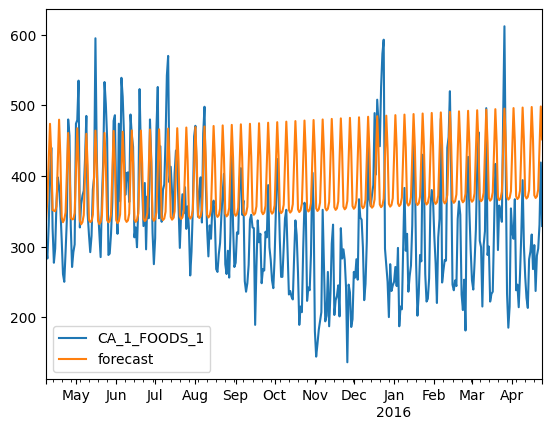

In [ ]:
# Initialize the model with the training data
model = SRX(train_data[col])

# Train the model on the given parameters
model.train(params)

# Predict the values using the model
test_data['forecast']=model.predict(test_data[col])

# Evaluate the model on the above predictions
print(model.evaluate())

# Plot the forecast against the actuals
test_data[[col, 'forecast']].plot()

### Random Forest Regressor

In [ ]:
rfr_params = {
    'n_estimators': 100,
    'max_depth': 25,
    'max_features':'log2',
    'min_samples_leaf': 10,
    'min_samples_split': 12,
    'bootstrap': False,
}

col = test_data.columns[0]

In [ ]:
model = RFR(train_data[[col]])

model.data_preprocess(7)

model.train_test_split(0.2)

model.fit(rfr_params)

model.predict()

rfr_mape = model.evaluate()

print(f'MAPE: {rfr_mape:.2f}%')

MAPE: 15.42%


## Hyperparameter Tuning

### SARIMAX_HYPEROPT

In [ ]:
# Initalize the model with the test and train data:
hp_model = SarimaxHyperopt(train_data[train_data.columns[0]], test_data[test_data.columns[0]])

# Tune the hyperparameters:
hp_model.hyperparameter_tune(num_evals=3)

# Returns the best parameters for the model
best = hp_model.best_params
print('Best parameters for the model: ', best)

  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 33%|███▎      | 1/3 [00:10<00:20, 10.23s/trial, best loss: 25.318970916421385]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 67%|██████▋   | 2/3 [00:29<00:15, 15.73s/trial, best loss: 25.318970916421385]

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



100%|██████████| 3/3 [00:40<00:00, 13.52s/trial, best loss: 25.318970916421385]
Best parameters for the model:  {'p': 2.0, 'd': 0.0, 'q': 3.0, 'P': 1.0, 'D': 1.0, 'Q': 3.0, 'm': 6.0}


### Random Forest Regressor Optuna

In [ ]:
# Initalize the model with the unprocessed raw data:
model = RFR_Optuna(train_data[[col]])

# Add new lagged columns to the data:
model.data_preprocess(7)

# Create the features and target:
model.train_test_split(0.2)

# Hyperparameter tuning:
model.hyperparameter_tune()

# Train the model:
model.fit()

# Make predictions:
model.predict()

# Evaluate the model:
rfr_mape = model.evaluate()

print(f'MAPE: {rfr_mape:.2f}%')

[I 2023-08-16 03:02:36,484] A new study created in memory with name: no-name-e814842a-e7a0-461b-91df-bbcbcd8377eb
[I 2023-08-16 03:02:36,548] Trial 0 finished with value: 15.082656666787306 and parameters: {'n_estimators': 41, 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 25, 'min_samples_split': 27, 'bootstrap': False}. Best is trial 0 with value: 15.082656666787306.
[I 2023-08-16 03:02:36,650] Trial 1 finished with value: 15.251114607282195 and parameters: {'n_estimators': 60, 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 13, 'min_samples_split': 14, 'bootstrap': False}. Best is trial 0 with value: 15.082656666787306.
[I 2023-08-16 03:02:36,790] Trial 2 finished with value: 14.958462923954746 and parameters: {'n_estimators': 85, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 24, 'min_samples_split': 25, 'bootstrap': True}. Best is trial 2 with value: 14.958462923954746.
[I 2023-08-16 03:02:36,958] Trial 3 finished with value: 15.07300775773

MAPE: 14.89%


In [ ]:
pred = mod.predict(X_test)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

NameError: name 'mod' is not defined

### Custom Methods

In [ ]:
### Custom Hyperparameter Tuning ###
'''
import itertools

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = range(1, 6)
q = range(0, 6)
d = range(1, 2)
P = range(0, 4)
Q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, d, Q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, freq='D'):
    
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False, 
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=1000)
                predictions = output.predict(start=1800,end=1913,dynamic=True)

                test_data = ts.iloc[1800:1913]
                mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

                ans.append([comb, combs, output.bic, mape])
                print('SARIMAX {} x {}12 : MAPE Calculated ={}'.format(comb, combs, mape))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'mape'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)
    
    return ans_df
    

    ### Apply function to your time series data ###
#Remember to change frequency to match your time series data
best_params = sarimax_gridsearch(df_1['Sales'], pdq, pdqs, freq='D')
best_params.head(20)
'''

In [ ]:
### Optuna Hyperparameter Optimization ###
'''
def objective(trial):
    p = trial.suggest_int('p', 0, 6)
    # d = trial.suggest_int('d', 1, 3)
    q = trial.suggest_int('q', 0, 6)
    P = trial.suggest_int('P', 0, 6)
    Q = trial.suggest_int('Q', 0, 6)
    # m = trial.suggest_int('m', 3, 8)
    srx = sm.tsa.statespace.SARIMAX(df_1['Sales'], 
                                    order=(p,1,q), 
                                    seasonal_order=(P,1,Q,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
    
    output = srx.fit(maxiter=1000)
    predictions = output.predict(start=1800,end=1913,dynamic=True)

    test_data = df_1['Sales'].iloc[1800:1913]
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
'''